In [1]:
## Import libraries
from datetime import datetime
from dateutil.relativedelta import relativedelta
import xarray as xr
from glob import glob
import numpy as np
from pathlib import Path
from scipy.special import gamma
from scipy.interpolate import interp1d

In [2]:
## Settings for calc functions

# Valid regions and their mapping to axis extents in [W, E, S, N] format 
# as well as timezones in hour +- GMT
regions = {
    # Central America (mostly Honduras-Nicaragua-Costa Rica)
    "ca": {"extent": [-91, -81, 7, 17], "tz": -6},
    # South America (mostly eastern Brazil)
    "sa": {"extent": [-65, -30, -15, 0], "tz": -3},
    # Western Australia (mostly near the west coast)
    "wa": {"extent": [113, 123, -35, -30], "tz": +8}
}

# Earliest and latest entries in each GLASS dataset
avhrr_earliest = "Jan-1981"
modis_earliest = "Mar-2000"
avhrr_latest = "Dec-2018"
modis_latest = "Dec-2021"
fapar_earliest = "Jan-1982"
fapar_latest = "Dec-2020"

# Size of chunks
chunksize = "500MB"

# Valid subsets to use as argument in climatologies and
# their mapping to month numbers for use in xarray time slicing
subsets = {
    "all": [1,2,3,4,5,6,7,8,9,10,11,12],
    "DJF": [12,1,2], "MAM": [3,4,5], "JJA": [6,7,8], "SON": [9,10,11],
    "Jan": [1], "Feb": [2], "Mar": [3], "Apr": [4], "May": [5], "Jun": [6],
    "Jul": [7], "Aug": [8], "Sep": [9], "Oct": [10], "Nov": [11], "Dec": [12]
}

# Valid variables for use in analysis
hours = list(range(0, 24))
vars_glass = ["lai", "fapar"]
vars_era5 = {
    "vars": {
        "surface": ["ws10", "ws100", "mslp", "t2", "slhf", "sshf"],
        "atmos": ["viec", "vipile", "vike", "tcclw", "tcwv", "nac"]
    },
    "dvars": {
        "surface": ["dws10", "dws100", "dmslp", "dt2", "dslhf", "dsshf"],
        "atmos": ["dviec", "dvipile", "dvike", "dtcclw", "dtcwv", "dnac"]
    }
}
vars_era5_all = (vars_era5["vars"]["surface"] + vars_era5["vars"]["atmos"] +
                 vars_era5["dvars"]["surface"] + vars_era5["dvars"]["atmos"])

# File number check to make sure data_download notebook was run correctly
number_of_glass_files = {"lai": {"avhrr": 1748, "modis": 1005},
                         "fapar": {"avhrr": 1702, "modis": 960}
                        }
number_of_era5_hour_files = 42

# Resolution of ERA5 dataset in degrees (used for regridding)
res_era5 = 0.25

# Speed (in m/s) for expected rate of exceedance analysis at 100 m
speed_eroe = 42.5

# Typical power curve for a 100 m turbine with 100 m rotor diameter and 
# a nameplate rating of around 2500 kW (used to compute gross capacity factor)
# Speeds are in m/s, powers are in kW, data from https://www.thewindpower.net
speeds_common = np.append(np.linspace(0, 25.5, 52), 999)
power_nameplate = 2500
# Vestas V100/2600
powers_vestas = np.array([0, 0, 0, 0, 0, 0, 21, 63, 115, 172, 239, 318, 405, 550,
                          706, 890, 1080, 1283, 1485, 1641, 1796, 1944, 2092, 2225,
                          2351, 2440, 2502, 2560, 2584, 2597, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 0, 0])
# Goldwind GW100/2500
powers_gw = np.array([0, 0, 0, 0, 0, 6, 34, 65, 101, 165, 235, 320, 409, 530, 655,
                      826, 997, 1196, 1394, 1669, 1943, 2170, 2313, 2415, 2458,
                      2485, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# GE Energy 2.5-100
powers_ge = np.array([0, 0, 0, 0, 0, 0, 10, 80, 160, 250, 340, 460, 590, 770, 952,
                      1170, 1389, 1650, 1869, 2100, 2260, 2400, 2487, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# Average
powers_avg = (powers_vestas/26*25 + powers_gw + powers_ge) / 3

In [3]:
## Supplementary functions for calc

def check_args(region=None, period_start=None, period_end=None,
               subset=None, var=None, hour=None, output_path=None):
    
    """
    Function to check whether input arguments are valid.
    
    Arguments:
        region (str)
        period_start (datetime.datetime)
        period_end (datetime.datetime)
        subset (str)
        var (str)
        hour (int)
        output_path (str)
    
    An assertion error will be raised if any of these arguments are invalid.
    """
    
    if region:
        assert region in [*regions], \
            f"region must be one of: {[*regions]}"
    if period_start:
        assert period_start >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
            f"period_start must be equal to or later than {avhrr_earliest}"        
    if period_end:
        assert period_end <= datetime.strptime(modis_latest, "%b-%Y"), \
            f"period_end must be equal to or earlier than {modis_latest}"
    if (period_start is not None) & (period_end is not None):
        assert period_end >= period_start, \
            "period_end must be equal to or later than period_start"        
    if subset:
        assert subset in [*subsets], \
            f"subset must be one of: {[*subsets]}"
    if var:
        assert var in vars_era5_all, \
            f"var must be one of: {vars_era5_all}"
    if hour:
        assert hour in hours, \
            f"hour must be one of: {hours}"
    if output_path:
        assert Path(output_path).exists() == False, \
            f"File with name already exists: {output_path}"

In [4]:
def glass_data_source_to_use(period_start, period_end):
    
    """
    Select which GLASS data source (AVHRR or MODIS) to use
    
    Arguments:
        period_start (datetime.datetime): Start of period coverage
        period_end (datetime.datetime): End of period coverage
        
    Returns:
        data_source (str): String indicating whether to use
                            "avhrr" or "modis" data for the given period
    
    For the given period, select the most appropriate GLASS data source to use 
    (out of AVHRR and MODIS). MODIS is preferentially selected where the given 
    period is completely contained within the time range of MODIS data. 
    Otherwise, AVHRR data is used. Periods which simultaneously cover both an 
    AVHRR-only period (i.e. before Mar-2000) and a MODIS-only period 
    (i.e. after Dec-2018) are prevented from selection since summary statistics
    over this range is subject to artefacts from the change in instruments.
    """
    
    assert period_start >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
        f"period_start must be equal to or later than {avhrr_earliest}"
    assert period_end <= datetime.strptime(modis_latest, "%b-%Y"), \
        f"period_end must be equal to or earlier than {modis_latest}"
    assert period_end >= period_start, \
        "period_end must be equal to or later than period_start"  
    
    if ((period_start >= datetime.strptime(avhrr_earliest, "%b-%Y")) & 
        (period_start < datetime.strptime(modis_earliest, "%b-%Y")) &
        (period_end <= datetime.strptime(avhrr_latest, "%b-%Y"))
       ):
        data_source = "avhrr"
    elif ((period_start >= datetime.strptime(modis_earliest, "%b-%Y")) &
          (period_end <= datetime.strptime(modis_latest, "%b-%Y"))
         ):
        data_source = "modis"
    else:
        raise Exception("If period_start is before Mar-2000, " +
                        "period_end cannot be after Dec-2018 " +
                        "(since this would cover both an " +
                        "AVHRR-only and a MODIS-only period)")
        
    return data_source

In [5]:
def regrid_era5(ds):
    
    """
    Regrid ERA5 xarray dataset
    
    Arguments:
        ds (xarray.Dataset): Dataset containing ERA5 data, loaded in
                                with xarray using the netcdf4 engine.
                                
    Returns:
        ds (xarray.Dataset): Dataset with regridded coordinates.
        
    Shifts each latitude coordinate south and longitude coordinate east by
    half a grid cell. This reflects the fact that coordinates in the
    original ERA5 dataset defines the north-western corner of each grid
    cell, whereas xarray plots assuming the coordinates refer to the centre.
    """
    
    ds = (ds
          .assign_coords({"latitude": ds.latitude - res_era5/2,
                          "longitude": (ds.longitude + 180 + res_era5/2) % 360 - 180})
          # Redundant measure just in case longitudes exceed 180 degrees
          .sortby("longitude")
         )
    return ds

In [6]:
def magnitude(x, y):
    
    """
    Calculate magnitude of 2D vectors given their components
    
    Arguments:
        x (xarray.DataArray): x-component of vectors
        y (xarray.DataArray): y-component of vectors
        
    Returns:
        da (xarray.DataArray); magnitude of vectors
        
    Performs a vectorised computation on two different data arrays
    containing the x and y component of some vectors and returns
    the magnitude of the vectors. Dask is allowed.
    """
    
    func = lambda a, b: np.sqrt(a**2 + b**2)
    da = xr.apply_ufunc(func, x, y, dask = "allowed")
    return da

In [7]:
def weibull_params(da_mean, da_std):
    
    """
    Obtain Weibull parameters for wind speed distribution from
    mean and standard deviation
    
    Arguments:
        da_mean (xarray.DataArray): mean wind speed
        da_std (xarray.DataArray): standard deviation of wind speed
    
    Returns:
        da_c (xarray.DataArray): scale parameter for empirical Weibull fit
        da_k (xarray.DataArray): shape parameter for empirical Weibull fit
    
    Performs a vectorised computation on two different data arrays
    containing the mean and standard deviation of wind speed and returns
    the Weibull scale and shape parameters for the fit. Dask is allowed.
    This method uses equations (15) and (16) from an article by Justus et al.
    (1977) titled "Methods for Estimating Wind Speed Frequency Distributions".
    Then 
    """
    
    k = lambda mean, std: (std / mean)**(-1.086)
    da_k = xr.apply_ufunc(k, da_mean, da_std, dask = "allowed")
    c = lambda mean, k: mean / gamma(1 + 1/k)
    da_c = xr.apply_ufunc(c, da_mean, da_k, dask = "allowed")
    return da_c, da_k

In [8]:
def weibull_eroe(da_c, da_k, ws):
    
    """
    Obtain the expected rate of exceedance for a particular wind speed
    from fitted Weibull parameters
    
    Arguments:
        da_c (xarray.DataArray): scale parameter for empirical Weibull fit
        da_k (xarray.DataArray): shape parameter for empirical Weibull fit
        ws (float or int): particular wind speed on which to conduct the
                                 expected rate of exceedance analysis
        
    Returns:
        da_eroe (xarray.DataArray): expected rate of exceedance from Weibull
        
    For the given Weibull parameters, the expected rate of exceedance for a 
    particular wind speed is computed as 1 minus the cumulative probability
    distribution for the Weibull fit.
    """
    
    assert (isinstance(ws, float) | isinstance(ws, int)), \
        "ws must have data type float or int"
    
    eroe = lambda c, k: np.exp(-(ws / c)**k)
    da_eroe = xr.apply_ufunc(eroe, da_c, da_k, dask = "allowed")
    return da_eroe

In [9]:
def gcf(da_ws, speeds, powers, power_max):
    
    """
    Compute the gross capacity factor for a typical wind turbine
    
    Arguments:
        da_ws (xarray.DataArray): wind speed data over a period
        speeds (numpy.ndarray): speed bins for the turbine's power curve
        powers (numpy.ndarray): powers for each speed bin according to manufacturer
                                  power curve data
        power_max (float or int): the maximum power which the turbine can produce
        
    Returns:
        da_gcf (xarray.DataArray): gross capacity factor over the period
        
    First uses the speeds and powers arguments to produce an interpolation
    function for the power curve. Then this interpolation function is applied
    to obtain the power at each wind speed data point in da_ws. Finally, this
    is divided over the maximum power and averaged over the period to obtain
    the gross capacity factor.
    """
    
    assert speeds.ndim == 1, "speeds must be a 1D numpy array"
    assert (speeds.dtype == "float64") | (speeds.dtype == "int64"), \
        "speeds must have data type 'float64' or 'int64'"
    assert powers.ndim == 1, "powers must be a 1D numpy array"
    assert (powers.dtype == "float64") | (powers.dtype == "int64"), \
        "powers must have data type 'float64' or 'int64'"
    assert isinstance(power_max, float) | isinstance(power_max, int), \
        "power_max must have data type float or int"
    
    power_curve = interp1d(speeds, powers, kind = "nearest")
    gcf_instant = lambda ws: power_curve(ws) / power_max
    da_gcf = (xr.apply_ufunc(gcf_instant, da_ws, dask = "allowed")
              .mean("time")
             )
    return da_gcf

In [10]:
## Low-level calc functions

def calc_glass_mean_climatology(region, period_start, period_end, subset):
    
    """
    Calculate mean leaf area index (MLAI) and mean fraction of absorbed
    photosynthetically active radiation (MFAPAR) climatology using GLASS data
    
    Arguments:
        region (str): Region to perform calculation over.
                        Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
                        Must be one of ["all", "DJF", "MAM", "JJA", "SON",
                        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
                        
    Returns:
        {region}_{period_start}_{period_end}_{subset}_glass-mean_{data_source}.nc:
                        Output netcdf4 file in data_processed file containing both 
                        MLAI and MFAPAR. {data_source} is automatically selected 
                        between ["avhrr", "modis"] based on selected period.
    
    For each grid cell, calculate the mean glass climatology (MLAI or MFAPAR) over 
    the period from period_start to period_end (inclusive). The calculation uses 
    8-day satellite HDF data from the data_raw folder as input, then outputs 
    the result as a netcdf4 file into the data_processed folder. MODIS data
    is preferentially used where the given period is completely contained 
    within the time range of MODIS data. Otherwise, AVHRR data is used.
    """
    
    # Assert that there are no errors in input arguments, and select the
    # appropriate data source (AVHRR or MODIS) to use depending on period
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    data_source = glass_data_source_to_use(period_start, period_end)
    output_path = ("../data_processed/{}_{}_{}_{}_glass-mean_{}.nc"
                   .format(region, period_start.strftime("%b-%Y"),
                           period_end.strftime("%b-%Y"), subset, data_source)
                  )
    check_args(region=region, period_start=period_start, period_end=period_end,
               subset=subset, output_path=output_path)

    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. The region and times (period and subset) are
    # selected within separate functions and uses different logic as compared with
    # filtering in the ERA5 datasets. This is because each GLASS file contains
    # global data whereas the ERA5 datasets were downloaded for each local region.
    
    def filter_glass_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files within
        # the input period and climatological subset within the original function 
        # arguments (by using dates contained within each file name). This is done 
        # (as opposed to using open_mfdataset then filtering) for scalability reasons 
        # since we may need to persist the data in RAM to speed up certain computations.
        time = file[-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        if ((time.month in subsets[subset]) &
            # We add an extra month to period_end here because period_end was
            # specified as a month, and conversion into a datetime object
            # defaults to the first (rather than last) day of that month
            (period_start <= time < period_end + relativedelta(months=1))
           ):
            return True
        else:
            return False
    
    def preprocess_glass(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It uses the dates in each raw data file name to assign a time dimension
        # and coordinate for the corresponding dataset. This then forms the
        # dimension along which the files are combined into a single dataset
        # and rechunked. This function also selects out the input region within
        # the original function arguments before the files are concatenated using
        # open_mfdataset (this is again done for persist scalability).
        time = ds.encoding["source"][-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        ds = (ds
              .expand_dims({"time": [time]})
              # Redundant measure just in case longitudes exceed 180 degrees
              .assign_coords({"x": (ds.x + 180) % 360 - 180})
              .sortby("x")
              .rename({"x": "longitude", "y": "latitude"})
              .drop_vars("spatial_ref")
              .squeeze("band", drop=True)
              )
        ds = ds.sel(longitude=slice(regions[region]["extent"][0],
                                    regions[region]["extent"][1]),
                    latitude=slice(regions[region]["extent"][3],
                                   regions[region]["extent"][2])
                   )
        return ds
    
    # The following code creates the mean climatology datasets for each GLASS
    # variable, by using the previous functions along with open_mfdataset.
    # An initally empty dataset is iteratively appended then merged so that
    # future scalability is possible in case one wishes to add more GLASS
    # variables to the vars_glass global python variable.
    datasets = []    
    for var in vars_glass:
        files_glass_all = glob(f"../data_raw/global_glass-{var}-{data_source}_8-day/" +
                               f"global_glass-{var}-{data_source}*")
        if len(files_glass_all) != number_of_glass_files[var][data_source]:
            print(f"Warning: Expected {number_of_glass_files[var][data_source]} " +
                  f"files in ../data_raw/global_glass-{var}-{data_source}_8-day/ " +
                  f"but got {len(files_glass_all)}. This could be because the " + 
                  "data_download.ipynb notebook was not run properly. Or it " +
                  "could be that the number of GLASS files on the server " +
                  "from which the data was downloaded has changed. Or it may " +
                  "be that the user has changed some files in this folder.")
        files_glass_filtered = list(filter(filter_glass_files, files_glass_all))
        files_glass_filtered.sort()
        # The if statement is to ensure an array full of NaNs is returned for MFAPAR
        # when the input period includes 1981 or 2021. At the time of writing, GLASS
        # FAPAR data is not available for these years.
        if (var == "fapar") & (
            (period_start < datetime.strptime(fapar_earliest, "%b-%Y")) |
            (period_end > datetime.strptime(fapar_latest, "%b-%Y"))
        ):
            # This line exploits the fact that the for loop runs in sequence and 
            # will have computed MLAI before it attempts to compute MFAPAR. 
            # Therefore an MLAI array with appropriate coordinates already exists 
            # in the datasets list and can be used to create an array of NaNs.
            ds_mean = (datasets[0]
                       .where(np.isnan(datasets[0]["mlai"]))
                       .rename({"mlai": "mfapar"})
                      )
            print("Warning: GLASS FAPAR data is not available for the years " +
                  f"{fapar_earliest[-4:]} and {fapar_latest[-4:]}. " +
                  "A data array with NaNs was returned for MFAPAR instead.")
        else:
            ds_mean = (xr.open_mfdataset(files_glass_filtered, engine = "rasterio",
                                         preprocess=preprocess_glass, parallel = True)
                       # Rechunking after open_mfdataset here is actually bad practice
                       # since it uses more RAM, but the chunks argument for
                       # open_mfdataset doesn't seem to work here for some reason
                       .chunk(chunks = {"time": chunksize})
                       .persist()
                       .mean("time")
                       .rename({"band_data": "m" + var})
                      )
        datasets.append(ds_mean)
    ds_glass_mean = xr.merge(datasets)
    
    # Create output file in data_processed folder
    try:
        ds_glass_mean.to_netcdf(output_path)
        print("Created " + output_path)
    except:
        print("Failed to create " + output_path)

In [11]:
%%time
calc_glass_mean_climatology("wa", "Jun-2001", "Aug-2006", "JJA")

AssertionError: File with name already exists: ../data_processed/wa_Jun-2001_Aug-2006_JJA_glass-mean_modis.nc

In [18]:
def calc_era5_weibull_climatology(region, period_start, period_end, subset):

    """
    Calculate climatology of Weibull scale and shape parameters for wind speeds
    at 10 m and 100 m above surface using ERA5 data
    
    Arguments:
        region (str): Region to perform calculation over.
                        Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
                        Must be of form "%b-%Y" eg. "Jul-1990".
                        Must be between "Jan-1981" and "Dec-2021".
        subset (str): Subset of period to perform calculation over.
                        Must be one of ["all", "DJF", "MAM", "JJA", "SON",
                        "Jan", "Feb", "Mar", "Apr", "May", "Jun",
                        "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"].
                        
    Returns:
        {region}_{period_start}_{period_end}_{subset}_era5-weibull.nc:
                        Output netcdf4 file in data_processed file containing
                        Weibull shape and scale parameters for wind speed
                        at 10 m and 100 m above surface.
    
    For each grid cell, calculate the Weibull shape and scale parameters over 
    the period from period_start to period_end (inclusive). The calculation uses 
    hourly ERA5 netcdf4 data from the data_raw folder as input, then outputs 
    the result as a netcdf4 file into the data_processed folder.
    """
    
    # Assert that there are no errors in input arguments
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    output_path = ("../data_processed/{}_{}_{}_{}_era5-weibull.nc"
                   .format(region, period_start.strftime("%b-%Y"),
                           period_end.strftime("%b-%Y"), subset)
                  )
    check_args(region=region, period_start=period_start, period_end=period_end,
               subset=subset, output_path=output_path)
    
    
    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. Together they select out the relevant files to read
    # and persist in memory only the data which is necessary for the computation.
    
    def filter_era5_hour_files(file):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files with
        # years within the input period. The following preprocess function also
        # selects out the relevant years (as well as months) but by applying a
        # filter on the list of file names we can avoid preprocessing a lot of
        # files and hence save on memory.
        year = int(file[-7:-3])
        if period_start.year <= year <= period_end.year:
            return True
        else:
            return False
    
    def preprocess_era5_hour(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It selects selects out only the wind speed data, and only for
        # the subset months. This is done for persist scalability.
        ds = (regrid_era5(ds)
              .sel(time = ds.time.dt.month.isin(subsets[subset]))
              .drop(["t2m", "msl", "slhf", "sshf"])
             )
        return ds
    
    # The following code opens the relevant hourly ERA5 files then uses the
    # u and v components of wind velocity to compute the magnitude (wind speed)
    files_era5_hour = glob(f"../data_raw/{region}_era5-slv-surface_hour/*.nc")
    files_era5_hour.sort()
    if len(files_era5_hour) != number_of_era5_hour_files:
        print(f"Warning: Expected {number_of_era5_hour_files} files in " +
              f"../data_raw/{region}_era5-slv-surface_hour/ but got " +
              f"{len(files_era5_hour)}. This could be because the " + 
              "data_download.ipynb notebook was not run properly. Or it " +
              "may be that the user has changed some files in this folder.")
    files_era5_hour_filtered = list(filter(filter_era5_hour_files, files_era5_hour))
    files_era5_hour_filtered.sort()
    ds_era5_hour = (xr.open_mfdataset(files_era5_hour_filtered, engine = "netcdf4",
                                     preprocess=preprocess_era5_hour, parallel = True)
                    # We add an extra month to period_end here because period_end was
                    # specified as a month, and conversion into a datetime object
                    # defaults to the first (rather than last) day of that month. The
                    # -1 hr is to avoid selecting first hour of the following month.
                    .sel(time = slice(period_start, period_end +
                                relativedelta(months=1, hours = -1)))
                    .chunk(chunks = {"time": chunksize})
                    .persist()
                   )
    da_ws10 = magnitude(ds_era5_hour["u10"], ds_era5_hour["v10"])
    da_ws100 = magnitude(ds_era5_hour["u100"], ds_era5_hour["v100"])
    
    # Compute the mean and standard deviation of wind speed and from these the 
    # Weibull scale and shape parameters, then combine into a single dataset
    da_ws10_mean = xr.DataArray(da_ws10.mean("time"), name = "ws10_mean")
    da_ws10_std = xr.DataArray(da_ws10.std("time"), name = "ws10_std")
    da_ws10_c, da_ws10_k = weibull_params(da_ws10_mean, da_ws10_std)
    da_ws10_c.name, da_ws10_k.name = "c10", "k10"
    da_ws100_mean = xr.DataArray(da_ws100.mean("time"), name = "ws100_mean")
    da_ws100_std = xr.DataArray(da_ws100.std("time"), name = "ws100_std")
    da_ws100_c, da_ws100_k = weibull_params(da_ws100_mean, da_ws100_std)
    da_ws100_c.name, da_ws100_k.name = "c100", "k100"
    da_ws100_eroe = weibull_eroe(da_ws100_c, da_ws100_k, speed_eroe)
    da_ws100_gcf = gcf(da_ws100, speeds_common, powers_avg, power_nameplate)
    da_ws100_eroe.name, da_ws100_gcf.name = "eroe100", "gcf100"
    ds_era5_weibull = xr.merge([da_ws10_mean, da_ws10_std, da_ws10_c, da_ws10_k,
                                da_ws100_mean, da_ws100_std, da_ws100_c,
                                da_ws100_k, da_ws100_eroe, da_ws100_gcf])
    
    # Create output file in data_processed folder
    try:
        ds_era5_weibull.to_netcdf(output_path)
        if period_start + relativedelta(years=5) > period_end:
            print("Warning: It is recommended to use at least 5 years of data " +
                  "for estimating the Weibull parameters.")
        print("Created " + output_path)
    except:
        print("Failed to create " + output_path)

In [20]:
%%time
ds_test = calc_era5_weibull_climatology("wa", "Dec-2004", "Feb-2014", "JJA")

AssertionError: File with name already exists: ../data_processed/wa_Dec-2004_Feb-2014_JJA_era5-weibull.nc

In [ ]:
def calc_diff(function, region, period1_start, period1_end, period2_start, period2_end, subset, var = None, hour = None):
    
    """
    Docstring here
    """
    
    # assert function is valid
    # assert (region, period1_start, period1_end, subset) is valid
    # assert (region, period2_start, period2_end, subset) is valid
    # make sure that check args returns strings which are dependent on input variable names
    # create output_path
    # assert output_path is valid
    # check if required files already exist, if not then invoke function to create them
    # calculate difference between files
    # treat clock arrow differences separately: they need to be between -12 and +12
    # output to netcdf

In [13]:
calc_era5_weibull_climatology in [calc_glass_mean_climatology, calc_era5_weibull_climatology, calc_stats_given_mdp]

NameError: name 'calc_stats_given_mdp' is not defined

In [5]:
from dask.distributed import Client
client = Client()
client

2022-08-19 16:25:49,932 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-1r7uaro6', purging
2022-08-19 16:25:49,932 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-33ofxd1l', purging
2022-08-19 16:25:49,933 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-qo0gto71', purging
2022-08-19 16:25:49,933 - distributed.diskutils - INFO - Found stale lock file and directory '/home/anthony/Thesis/test/dask-worker-space/worker-gitbx460', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36421,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:33269,Total threads: 3
Dashboard: http://127.0.0.1:46465/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:38731,


In [12]:
client.close()

In [ ]:
# subsets = ["all", "DJF", "MAM", "JJA", "SON",
#            "Jan", "Feb", "Mar", "Apr", "May", "Jun",
#            "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [ ]:
# months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#           "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# years = range(1981, 2022)

In [ ]:
    # assert(isinstance(periodstart, str)), {"periodstart must be a string " +
    #                                       "of form '%b-%Y' eg. Jul-1990"}
    # assert(len(periodstart)==8), {"periodstart must be a string " +
    #                               "of form '%b-%Y' eg. Jul-1990"}
    # assert(periodstart[3]=="-"), {"periodstart must be a string " +
    #                               "of form '%b-%Y' eg. Jul-1990"}
    # assert(periodstart[0:3] in months), {"periodstart must be a string " +
    #                                      "of form '%b-%Y' eg. Jul-1990"}
    # assert(int(periodstart[4:8]) in years), {"periodstart must be a string " +
    #                                          "of form '%b-%Y' eg. Jul-1990"}

In [21]:
test = xr.open_dataset("../data_processed/wa_Dec-2004_Feb-2014_JJA_era5-weibull.nc")
test

<xarray.Dataset>
Dimensions:     (longitude: 41, latitude: 21)
Coordinates:
  * longitude   (longitude) float32 113.1 113.4 113.6 ... 122.6 122.9 123.1
  * latitude    (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
Data variables:
    ws10_mean   (latitude, longitude) float32 ...
    ws10_std    (latitude, longitude) float32 ...
    c10         (latitude, longitude) float32 ...
    k10         (latitude, longitude) float32 ...
    ws100_mean  (latitude, longitude) float32 ...
    ws100_std   (latitude, longitude) float32 ...
    c100        (latitude, longitude) float32 ...
    k100        (latitude, longitude) float32 ...
    eroe100     (latitude, longitude) float32 ...
    gcf100      (latitude, longitude) float64 ...

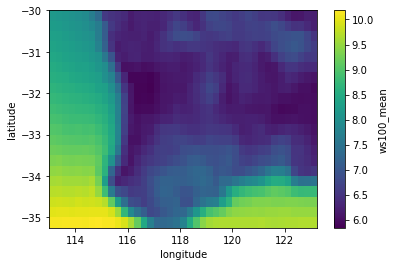

In [25]:
test["ws100_mean"].plot()

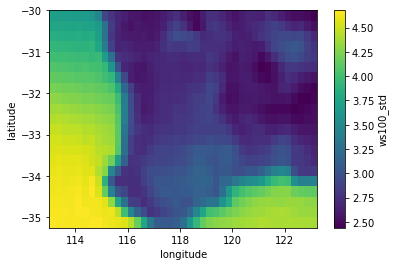

In [26]:
test["ws100_std"].plot()

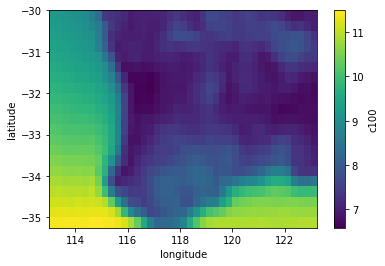

In [28]:
test["c100"].plot()

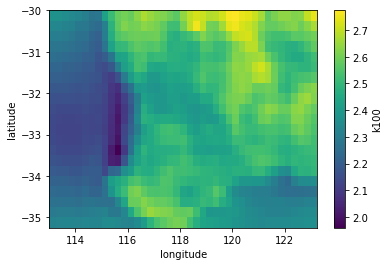

In [29]:
test["k100"].plot()

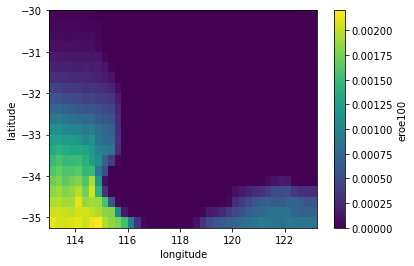

In [31]:
test["eroe100"].plot()

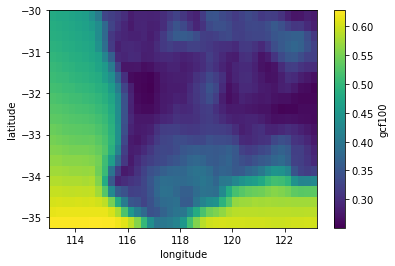

In [30]:
test["gcf100"].plot()

In [23]:
test["eroe100"].where(test["eroe100"]==test["eroe100"].max(), drop = True).squeeze()

<xarray.DataArray 'eroe100' ()>
array(0.00220415, dtype=float32)
Coordinates:
    longitude  float32 114.9
    latitude   float32 -35.12